In [174]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt

## Read the Data

Step 1: Actually figure out the IDs of the zebras ...

In [175]:
hr_path = 'log_human_readable.txt'
with open(hr_path, 'r') as f:
    txt = f.read()

p = re.compile("Zebra-\d{1,100}")
zebras_raw = p.findall(txt)
zebras_raw_set = set(zebras_raw)
zebra_ids = set()
for zebra_raw in zebras_raw_set:
    zebra_ids.add(int(zebra_raw.split('-')[1]))
print(zebra_ids)

{32, 19, 20, 23, 27, 28, 30}


Step 2: Read the JSON file (credit to Campuswire for code)

In [176]:
data_path = 'log_json.txt'
data = "["
with open(data_path) as f:
    for line in f:
        if len(line) > 1: # skip lines with one char
            stripped = line.strip()
            cleaned = stripped[1:-1]
            data += cleaned + ","
data = data[:-1]
data += "]"
data_dict = json.loads(data)
print('Animal data points recorded:', len(data_dict))
# 14676

Animal data points recorded: 14676


Step 3: Extract all zebra data from the JSON file based on the zebra IDs

In [177]:
zebra_data = []
for data in data_dict:
    did = data['deviceId']
    if (int(did.split('_')[1]) in zebra_ids):
        zebra_data.append(data)
print('Zebra data points recorded:', len(zebra_data))


Zebra data points recorded: 6089


## Answer the Questions

In [178]:
PULSE_OXIMETER = 31
LOCATION = 27
TEMPERATURE = 24
HUMIDITY = 25

def get_device_id(data):
    return int(data['deviceId'].split('_')[1])

Get lists of data for each zebra ordered by ascending timestamp (this just requires reading the data in ascending order).

In [179]:
zebra_pulse = {}
zebra_oxygen = {}
zebra_location = {}
zebra_temperature = {}
zebra_humidity = {}
for id in zebra_ids:
    zebra_pulse[id] = []
    zebra_oxygen[id] = []
    zebra_location[id] = []
    zebra_temperature[id] = []
    zebra_humidity[id] = []

for data in zebra_data:
    curr_id = get_device_id(data)
    curr_timestamp = data['timestamp']
    sensor_readings = data['sensors']
    for reading in sensor_readings:
        type = reading['type']
        if (type == PULSE_OXIMETER):
            pulse = reading['input']['pulseOxygen'][0]
            oxygen = reading['input']['pulseOxygen'][1]
            zebra_pulse[curr_id].append((curr_timestamp, pulse))
            zebra_oxygen[curr_id].append((curr_timestamp, oxygen))
        elif (type == LOCATION):
            location = tuple(reading['input']['location'])
            zebra_location[curr_id].append((curr_timestamp, location))
        elif (type == TEMPERATURE):
            temperature = reading['input']['temperature']
            zebra_temperature[curr_id].append((curr_timestamp, temperature))
        elif (type == HUMIDITY):
            humidity = reading['input']['humidity']
            zebra_humidity[curr_id].append((curr_timestamp, humidity))

# verify sorted
for id in zebra_ids:
    assert(zebra_pulse[id] == sorted(zebra_pulse[id]))
    assert(zebra_oxygen[id] == sorted(zebra_oxygen[id]))
    assert(zebra_location[id] == sorted(zebra_location[id]))
    assert(zebra_temperature[id] == sorted(zebra_temperature[id]))
    assert(zebra_humidity[id] == sorted(zebra_humidity[id]))


In [180]:
def extract_values(timestamp_value_array):
    arr = []
    for tv in timestamp_value_array:
        arr.append(tv[1])
    return arr

Plot histograms of the pulse and oxygen levels.

{32, 19, 20, 23, 27, 28, 30}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


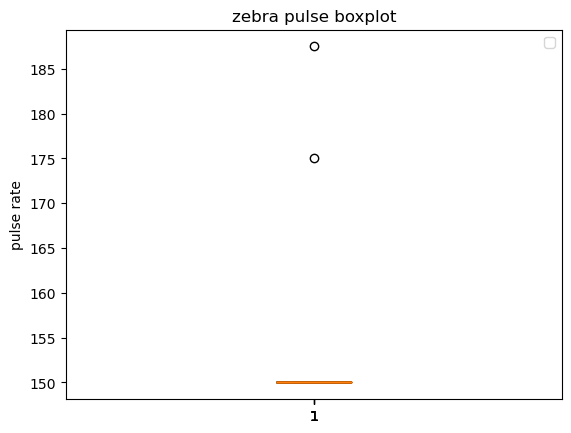

In [181]:
zebra_pulse_values = {}
for id in zebra_pulse:
    zebra_pulse_values[id] = extract_values(zebra_pulse[id])

plt.title('zebra pulse boxplot')
for id in zebra_ids:
    plt.boxplot(zebra_pulse_values[id])
plt.legend(loc='upper right')
plt.ylabel('pulse rate')
plt.show()

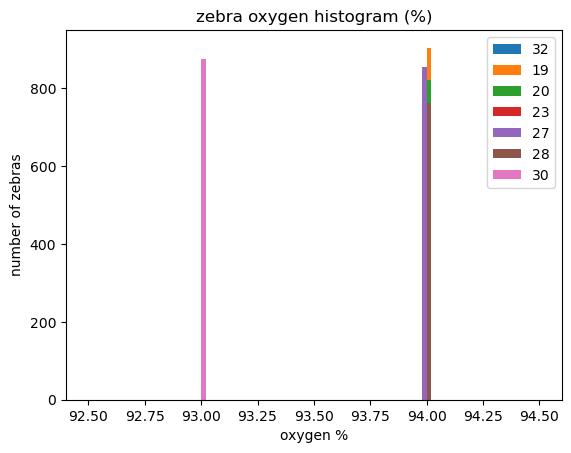

In [182]:
zebra_oxygen_values = {}
for id in zebra_oxygen:
    zebra_oxygen_values[id] = extract_values(zebra_oxygen[id])

plt.title('zebra oxygen histogram (%)')
for id in zebra_ids:
    plt.hist(zebra_oxygen_values[id], bins=50, label=str(id))
plt.legend(loc='upper right')
plt.xlabel('oxygen %')
plt.ylabel('number of zebras')
plt.show()

Plot zebra locations over time

{32, 19, 20, 23, 27, 28, 30}

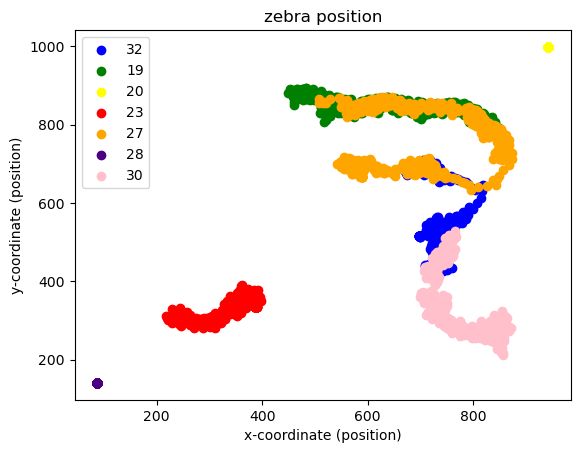

In [183]:
xs = {}
ys = {}
ts = {}
for id in zebra_location:
    xs[id] = []
    ys[id] = []
    ts[id] = []
    for location in zebra_location[id]:
        ts[id].append(location[0])
        xs[id].append(location[1][0])
        ys[id].append(location[1][1])

fig, ax = plt.subplots()
colors = {32: 'blue', 19: 'green', 20: 'yellow', 23: 'red', 27: 'orange', 28: 'indigo', 30: 'pink'}

for id in zebra_ids:
    ax.scatter(xs[id], ys[id], c=colors[id], label=str(id))
plt.legend(loc='upper left')
plt.xlabel('x-coordinate (position)')
plt.ylabel('y-coordinate (position)')
plt.title('zebra position')
plt.show()

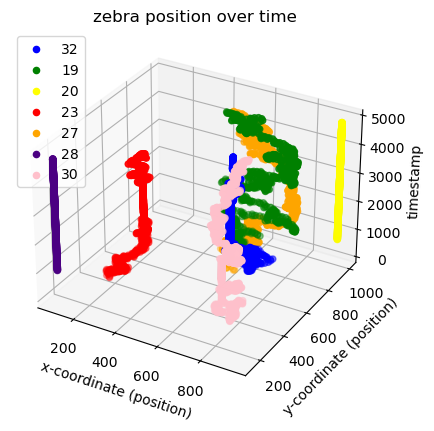

In [184]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for id in zebra_ids:
    ax.scatter(xs[id], ys[id], ts[id], c=colors[id], label=str(id))
plt.legend(loc='upper left')
plt.title('zebra position over time')
ax.set_xlabel('x-coordinate (position)')
ax.set_ylabel('y-coordinate (position)')
ax.set_zlabel('timestamp')
plt.show()


CDF Plot

In [185]:
# calculate speeds
speeds = {}
for id in xs:
    speeds[id] = []
    total_positions = len(xs[id])
    for i in range(0, total_positions-1, 1):
        position_delta = (xs[id][i+1] - xs[id][i], ys[id][i+1] - ys[id][i])
        distance_travelled = np.linalg.norm(position_delta)
        time_delta = ts[id][i+1] - ts[id][i]
        speed = distance_travelled / time_delta
        speeds[id].append(speed)

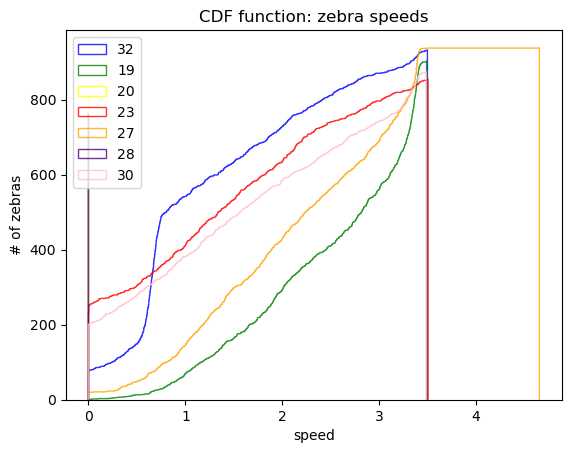

In [186]:
# actually plot the cdf
for id in speeds:
    plt.hist(speeds[id], bins=len(speeds[id]), cumulative=True, label=str(id),
            histtype='step', alpha=0.8, color=colors[id])
plt.xlabel('speed')
plt.ylabel('# of zebras')
plt.title("CDF function: zebra speeds")
plt.legend(loc='upper left')
plt.show()

Poacher test (check last timestamp)

In [187]:
max_ts = {}
for id in ts:
    max_ts[id] = max(ts[id])
print(max_ts)

{32: 4836.32, 19: 4836.32, 20: 4836.32, 23: 4836.32, 27: 4836.32, 28: 4836.32, 30: 4836.32}


## Answer the Elephant Questions

(Same stuff as above, except for elephants)

In [188]:
hr_path = 'log_human_readable.txt'
with open(hr_path, 'r') as f:
    txt = f.read()

p = re.compile("Elephant-\d{1,100}")
elephants_raw = p.findall(txt)
elephant_raw_set = set(elephants_raw)
elephant_ids = set()
for elephant_raw in elephant_raw_set:
    elephant_ids.add(int(elephant_raw.split('-')[1]))
print(elephant_ids)

{1, 4, 5, 6, 11}


In [189]:
elephant_data = []
for data in data_dict:
    did = data['deviceId']
    if (int(did.split('_')[1]) in elephant_ids):
        elephant_data.append(data)
print('Elephant data points recorded:', len(elephant_data))


Elephant data points recorded: 4618


In [190]:
elephant_pulse = {}
elephant_oxygen = {}
elephant_location = {}
elephant_temperature = {}
elephant_humidity = {}
for id in elephant_ids:
    elephant_pulse[id] = []
    elephant_oxygen[id] = []
    elephant_location[id] = []
    elephant_temperature[id] = []
    elephant_humidity[id] = []

for data in elephant_data:
    curr_id = get_device_id(data)
    curr_timestamp = data['timestamp']
    sensor_readings = data['sensors']
    for reading in sensor_readings:
        type = reading['type']
        if (type == PULSE_OXIMETER):
            pulse = reading['input']['pulseOxygen'][0]
            oxygen = reading['input']['pulseOxygen'][1]
            elephant_pulse[curr_id].append((curr_timestamp, pulse))
            elephant_oxygen[curr_id].append((curr_timestamp, oxygen))
        elif (type == LOCATION):
            location = tuple(reading['input']['location'])
            elephant_location[curr_id].append((curr_timestamp, location))
        elif (type == TEMPERATURE):
            temperature = reading['input']['temperature']
            elephant_temperature[curr_id].append((curr_timestamp, temperature))
        elif (type == HUMIDITY):
            humidity = reading['input']['humidity']
            elephant_humidity[curr_id].append((curr_timestamp, humidity))

# verify sorted
for id in elephant_ids:
    assert(elephant_pulse[id] == sorted(elephant_pulse[id]))
    assert(elephant_oxygen[id] == sorted(elephant_oxygen[id]))
    assert(elephant_location[id] == sorted(elephant_location[id]))
    assert(elephant_temperature[id] == sorted(elephant_temperature[id]))
    assert(elephant_humidity[id] == sorted(elephant_humidity[id]))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


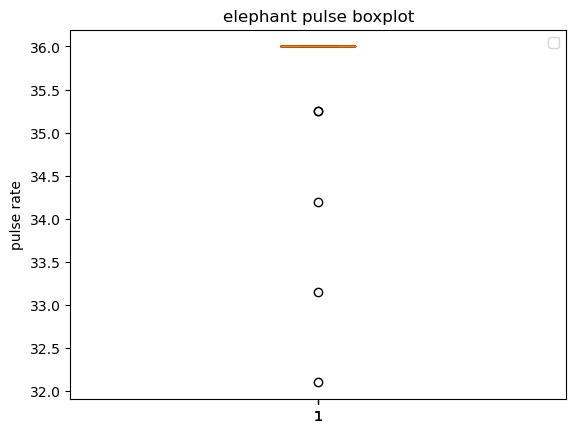

In [191]:
elephant_pulse_values = {}
for id in elephant_pulse:
    elephant_pulse_values[id] = extract_values(elephant_pulse[id])

plt.title('elephant pulse boxplot')
for id in elephant_ids:
    plt.boxplot(elephant_pulse_values[id])
plt.legend(loc='upper right')
plt.ylabel('pulse rate')
plt.show()

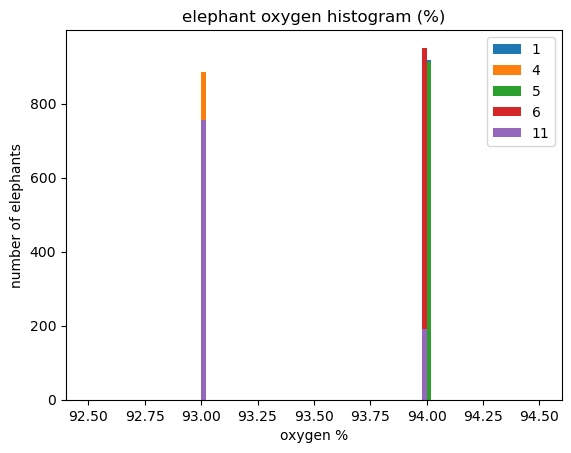

In [192]:
elephant_oxygen_values = {}
for id in elephant_oxygen:
    elephant_oxygen_values[id] = extract_values(elephant_oxygen[id])

plt.title('elephant oxygen histogram (%)')
for id in elephant_ids:
    plt.hist(elephant_oxygen_values[id], bins=50, label=str(id))
plt.legend(loc='upper right')
plt.xlabel('oxygen %')
plt.ylabel('number of elephants')
plt.show()

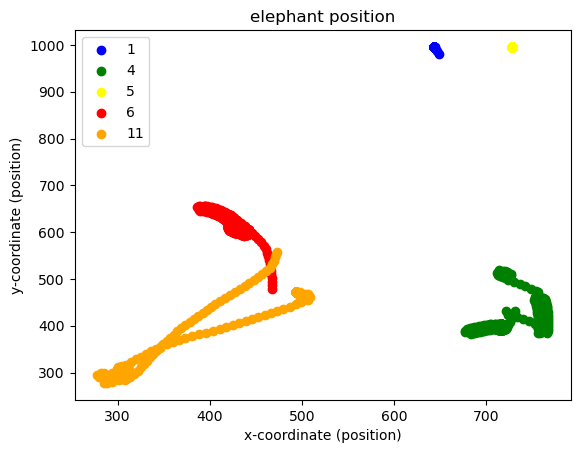

In [193]:
xs = {}
ys = {}
ts = {}
for id in elephant_location:
    xs[id] = []
    ys[id] = []
    ts[id] = []
    for location in elephant_location[id]:
        ts[id].append(location[0])
        xs[id].append(location[1][0])
        ys[id].append(location[1][1])

fig, ax = plt.subplots()
colors = {1: 'blue', 4: 'green', 5: 'yellow', 6: 'red', 11: 'orange'}

for id in elephant_ids:
    ax.scatter(xs[id], ys[id], c=colors[id], label=str(id))
plt.legend(loc='upper left')
plt.xlabel('x-coordinate (position)')
plt.ylabel('y-coordinate (position)')
plt.title('elephant position')
plt.show()

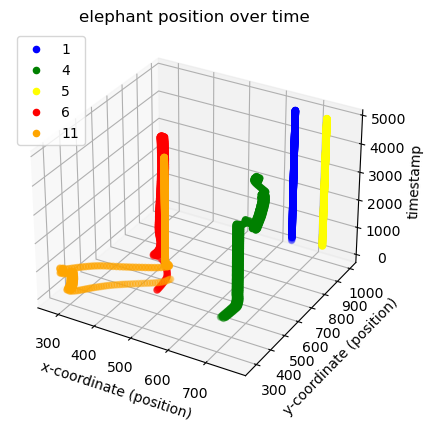

In [194]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for id in elephant_ids:
    ax.scatter(xs[id], ys[id], ts[id], c=colors[id], label=str(id))
plt.legend(loc='upper left')
plt.title('elephant position over time')
ax.set_xlabel('x-coordinate (position)')
ax.set_ylabel('y-coordinate (position)')
ax.set_zlabel('timestamp')
plt.show()


In [195]:
# calculate speeds
speeds = {}
for id in xs:
    speeds[id] = []
    total_positions = len(xs[id])
    for i in range(0, total_positions-1, 1):
        position_delta = (xs[id][i+1] - xs[id][i], ys[id][i+1] - ys[id][i])
        distance_travelled = np.linalg.norm(position_delta)
        time_delta = ts[id][i+1] - ts[id][i]
        speed = distance_travelled / time_delta
        speeds[id].append(speed)

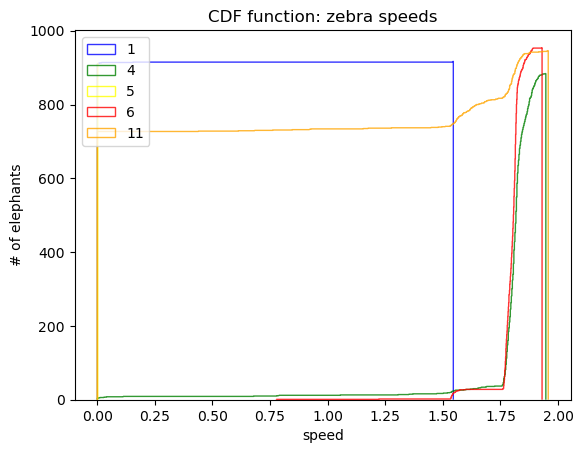

In [196]:
# actually plot the cdf
for id in speeds:
    plt.hist(speeds[id], bins=len(speeds[id]), cumulative=True, label=str(id),
            histtype='step', alpha=0.8, color=colors[id])
plt.xlabel('speed')
plt.ylabel('# of elephants')
plt.title("CDF function: zebra speeds")
plt.legend(loc='upper left')
plt.show()

In [197]:
max_ts = {}
for id in ts:
    max_ts[id] = max(ts[id])
print(max_ts)

{1: 4836.32, 4: 4836.32, 5: 4836.32, 6: 4836.32, 11: 4836.32}
